In [0]:
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d
import copy
from mpl_toolkits.mplot3d import Axes3D

In [0]:
# -*- coding: utf-8 -*-
# %reset -f
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel, RBF, ConstantKernel



class BayesianOptimizer():
  def __init__(self,X_init,y_init,X_explore_space,maximize=False,acquisition_function_flag=2):
    self.X_init = X_init
    self.y_init = y_init
    self.X_explore_space=X_explore_space
    self.X=copy.deepcopy(self.X_explore_space)
    self.X_iter = copy.deepcopy(X_init)
    self.maximize=maximize
    
    if maximize:
      self.y_iter = copy.deepcopy(y_init)
    else:
      self.y_iter = -copy.deepcopy(y_init)

    self.gaussian_process_model= GaussianProcessRegressor(ConstantKernel() * RBF() + WhiteKernel()+ConstantKernel() )
    self.acquisition_function_flag=acquisition_function_flag
    self.cumulative_variance=None

    self.X_train=None
    self.y_train=None

  def update(self,x_sample_idx,next_y):
    '''
    Update the known whole x-y relation through new experiment. The inputs are new x,y information.
    
    Inputs
    ----------
    x_sample_idx: The index of next x in the X exploration space
    next_y : next y value
    
    '''
    if self.maximize==False:
      next_y=-next_y

    cumulative_variance = np.empty(len(self.X))

    self.X_iter = np.append(self.X_iter, np.reshape(self.X[x_sample_idx, :], (1, self.X.shape[1])), 0)
    self.y_iter= np.append(self.y_iter, next_y)
    self.X = np.delete(self.X, x_sample_idx, 0)
    self.cumulative_variance = np.delete(self.cumulative_variance, x_sample_idx)
    
  def get_current_optimized_value(self):
    if self.maximize:
        #print('max of current y : {0}'.format(max(self.y_iter)))
        return max(self.y_iter)
    else:
        #print('min of current y : {0}'.format(-max(self.y_iter)))
        return -max(self.y_iter)
        
  def fit_and_calc_next_candidate(self):
    '''
    Fit gaussian process model for the known x-y data, and calc candidate point of optimization
    '''
    # Bayesian optimization
    selected_candidate_number, selected_X_candidate, cumulative_varianc = self.bayesianoptimization(self.X_iter, self.y_iter, self.X,
                                                                                                self.acquisition_function_flag,
                                                                                                self.cumulative_variance)
    return selected_candidate_number, selected_X_candidate, cumulative_varianc

  def bayesianoptimization(self,X, y, candidates_of_X, acquisition_function_flag, cumulative_variance=None):
    """
    Bayesian optimization(maximization)

    Gaussian process regression model is constructed between X and y.
    A candidate of X with the highest acquisition function is selected using the model from candidates of X.

    Parameters
    ----------
    X: numpy.array or pandas.DataFrame
        m x n matrix of X-variables of training dataset (m is the number of samples and n is the number of X-variables)
    y: numpy.array or pandas.DataFrame
        m x 1 vector of a y-variable of training dataset
    candidates_of_X: numpy.array or pandas.DataFrame
        Candidates of X
    acquisition_function_flag: int
        1: Mutual information (MI), 2: Expected improvement(EI), 
        3: Probability of improvement (PI) [0: Estimated y-values]
    cumulative_variance: numpy.array or pandas.DataFrame
        cumulative variance in mutual information (MI)[acquisition_function_flag=1]

    Returns
    -------
    selected_candidate_number : int
        selected number of candidates_of_X
    selected_X_candidate : numpy.array
        selected X candidate
    cumulative_variance: numpy.array
        cumulative variance in mutual information (MI)[acquisition_function_flag=1]
    """

    X = np.array(X)
    y = np.array(y)
    if cumulative_variance is None:
        self.cumulative_variance = np.empty(len(self.X))
    else:
        self.cumulative_variance = np.array(cumulative_variance)

    relaxation_value = 0.01
    delta = 10 ** -6
    alpha = np.log(2 / delta)

    # scaling
    autoscaled_X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
    autoscaled_candidates_of_X = (candidates_of_X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
    autoscaled_y = (y - y.mean(axis=0)) / y.std(axis=0, ddof=1)

    # keep x y values
    self.X_train=X
    self.y_train=y

    # learn
    self.gaussian_process_model.fit(autoscaled_X, autoscaled_y)
    autoscaled_estimated_y_test, autoscaled_std_of_estimated_y_test = self.gaussian_process_model.predict(
        autoscaled_candidates_of_X, return_std=True)

    if acquisition_function_flag == 1:
        acquisition_function_values = autoscaled_estimated_y_test + alpha ** 0.5 * (
                (autoscaled_std_of_estimated_y_test ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
        cumulative_variance = cumulative_variance + autoscaled_std_of_estimated_y_test ** 2
    elif acquisition_function_flag == 2:
        acquisition_function_values = (autoscaled_estimated_y_test - max(autoscaled_y) - relaxation_value) * \
                                      norm.cdf((autoscaled_estimated_y_test - max(autoscaled_y) - relaxation_value) /
                                               autoscaled_std_of_estimated_y_test) + \
                                      autoscaled_std_of_estimated_y_test * \
                                      norm.pdf((autoscaled_estimated_y_test - max(autoscaled_y) - relaxation_value) /
                                               autoscaled_std_of_estimated_y_test)
    elif acquisition_function_flag == 3:
        acquisition_function_values = norm.cdf(
            (autoscaled_estimated_y_test - max(autoscaled_y) - relaxation_value) / autoscaled_std_of_estimated_y_test)
    elif acquisition_function_flag == 0:
        acquisition_function_values = autoscaled_estimated_y_test

    selected_candidate_number = np.where(acquisition_function_values == max(acquisition_function_values))[0][0]
    selected_X_candidate = candidates_of_X[selected_candidate_number, :]

    return selected_candidate_number, selected_X_candidate, cumulative_variance

  def predict(self,X):
    # scaling
    autoscaled_X = (X - self.X_train.mean(axis=0)) / self.X_train.std(axis=0, ddof=1)
    autoscaled_y = (y - self.y_train.mean(axis=0)) / self.y_train.std(axis=0, ddof=1)

    # predict
    autoscaled_estimated_y_test, autoscaled_std_of_estimated_y_test = self.gaussian_process_model.predict(autoscaled_X, return_std=True)

    # inverse to the original x y space
    inverse_estimated_y=autoscaled_estimated_y_test* self.y_train.std(axis=0, ddof=1)+self.y_train.mean(axis=0)
    inverse_estimated_y_std=autoscaled_std_of_estimated_y_test* self.y_train.std(axis=0, ddof=1)

    if self.maximize==True:
      return inverse_estimated_y,inverse_estimated_y_std

    else:
      return  -inverse_estimated_y,-inverse_estimated_y_std



# Test function 

In [0]:
# Define unknow function to minimize
def func(x1,x2):
    y=np.log(( 1 + ((x1 + x2 + 1) ** 2) * (
        18 - 14 * x1 + 3 * x1 ** 2 - 14 * x2 + 6 * x1 * x2 + 3 * x2 ** 2))*(30 + ((2 * x1 - 3 * x2) ** 2) * (
        18 - 32 * x1 + 12 * x1 ** 2 + 48 * x2 - 36 * x1 * x2 + 27 * x2 ** 2)))
    
    return y

min of y : 1.1309397918118815


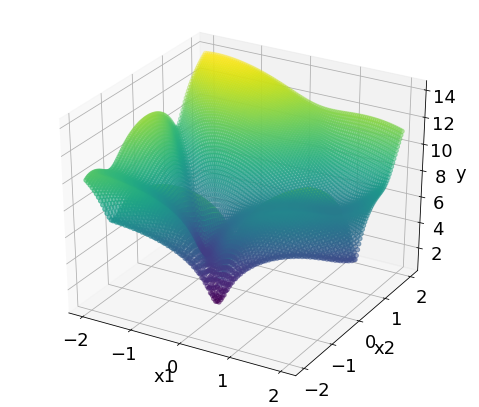

In [8]:
# define exploration space
N=100
x1 = np.linspace(-2, 2, N)
x2 = np.linspace(-2, 2, N)

# Make data set X (samples N^features , features=2) y (samples N^features)
X1,X2= np.meshgrid(x1,x2)
Z=func(X1,X2) # Test function. this is replaced to a real test result.
X=np.concatenate([X1.reshape(-1)[:,None],X2.reshape(-1)[:,None]],axis=1)
y=Z.reshape(-1)

print('min of y : {0}'.format(min(y)))

# plot
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(X[:, 0], X[:, 1], y, c=y)
plt.tight_layout()
plt.show()

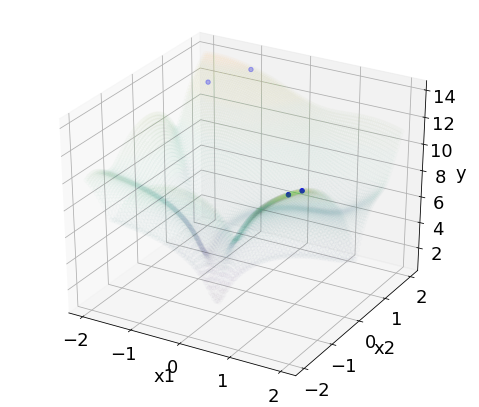

In [12]:
# initial x-y set which is already known by test
number_of_first_samples=4

bad_sample_number = np.where(y > 12)[0] # intentionaly choose not optimized data point for this test
bad_X = X[bad_sample_number, :]
bad_y = y[bad_sample_number]
np.random.seed(seed=1)
first_sample_numbers = np.random.randint(0, len(bad_y), number_of_first_samples)
X_train = bad_X[first_sample_numbers, :]
y_train = bad_y[first_sample_numbers]
X = np.delete(X, bad_sample_number[first_sample_numbers], 0)
y = np.delete(y, bad_sample_number[first_sample_numbers])

# plot
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(X[:, 0], X[:, 1], y, c=y,alpha=0.01)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='blue')

plt.tight_layout()
plt.show()

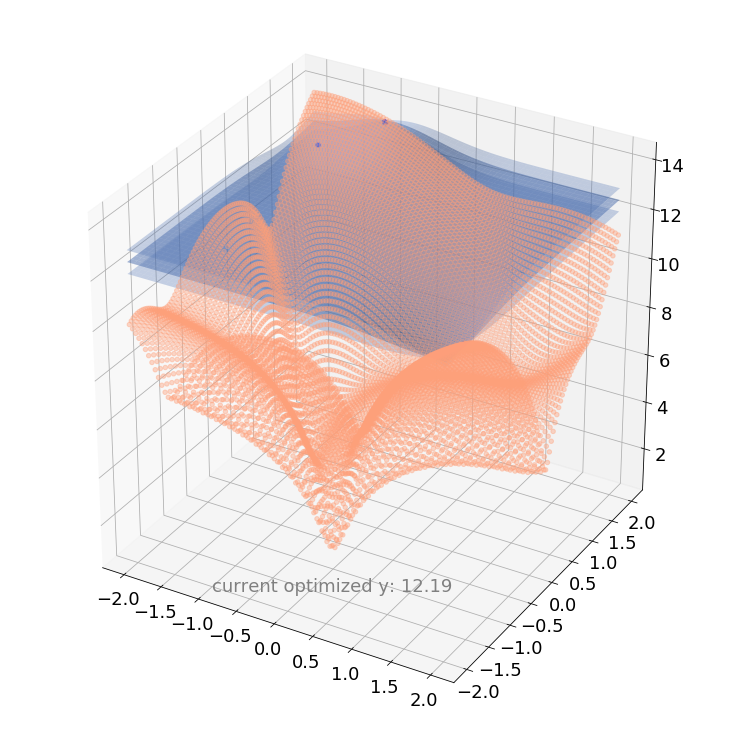

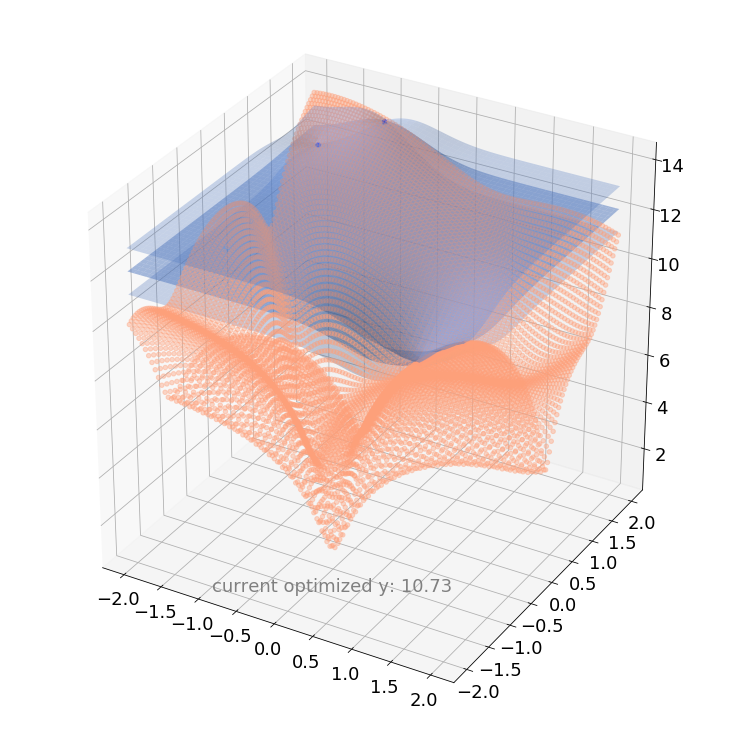

In [13]:
# initialize optimizer
bo=BayesianOptimizer(X_train,y_train,X,maximize=False,acquisition_function_flag=2)


X_original=np.concatenate([X1.reshape(-1)[:,None],X2.reshape(-1)[:,None]],axis=1)


for i in range(2):
  # fit and suggest next point
  selected_candidate_number, selected_X_candidate, cumulative_varianc=bo.fit_and_calc_next_candidate()
  inverse_estimated_y,inverse_estimated_y_std=(bo.predict(X_original))
  inverse_estimated_y=inverse_estimated_y.reshape(N,N)
  inverse_estimated_y_std=inverse_estimated_y_std.reshape(N,N)

  current_max_y=bo.get_current_optimized_value()

    
  # plot current status
  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)
  ax.scatter(X[:, 0], X[:, 1], y, c='lightsalmon',alpha=0.4)
  ax.scatter(bo.X_train[:, 0], bo.X_train[:, 1], -bo.y_train, c='b',alpha=1)
  ax.scatter(bo.X_train[-1, 0], bo.X_train[-1, 1], -bo.y_train[-1], c='r',alpha=1)
  ax.plot_surface(X1,X2,inverse_estimated_y,alpha=0.5,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y+inverse_estimated_y_std,alpha=0.3,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y-inverse_estimated_y_std,alpha=0.3,color='cornflowerblue') 
  ax.text(-1, -2, 0, 'current optimized y: {}'.format(np.round(current_max_y,2)), color='gray')
  plt.show()
  
  # calc next point
  next_y=func(selected_X_candidate[0],selected_X_candidate[1])
  bo.update(selected_candidate_number,next_y)



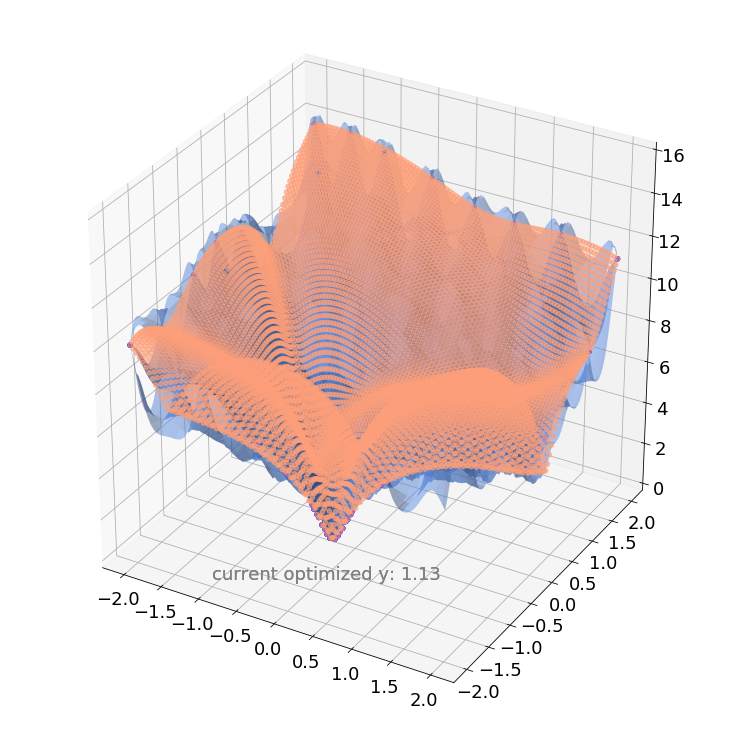

In [14]:


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
# First set up the figure, the axes, and the plot element
x_max=60


bo=BayesianOptimizer(X_train,y_train,X,maximize=False,acquisition_function_flag=2)

tot_frame=200
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ims=[]
def update_anim(i):
 
  # delete current plot
  if i != 0:
      plt.cla()                     

  #print(i)
      
  # fit and suggest next point
  selected_candidate_number, selected_X_candidate, cumulative_varianc=bo.fit_and_calc_next_candidate()
  inverse_estimated_y,inverse_estimated_y_std=(bo.predict(X_original))
  inverse_estimated_y=inverse_estimated_y.reshape(N,N)
  inverse_estimated_y_std=inverse_estimated_y_std.reshape(N,N)

  current_max_y=bo.get_current_optimized_value()

    
  # plot current status
  ax.scatter(X[:, 0], X[:, 1], y, c='lightsalmon',alpha=0.4)
  ax.scatter(bo.X_train[:, 0], bo.X_train[:, 1], -bo.y_train, c='b',alpha=1)
  ax.scatter(bo.X_train[-1, 0], bo.X_train[-1, 1], -bo.y_train[-1], c='r',alpha=1)
  ax.plot_surface(X1,X2,inverse_estimated_y,alpha=0.5,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y+inverse_estimated_y_std,alpha=0.3,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y-inverse_estimated_y_std,alpha=0.3,color='cornflowerblue') 
  ax.text(-1, -2, 0, 'current optimized y: {}'.format(np.round(current_max_y,2)), color='gray')
  ax.set_zlim(0,16)


  # calc next point
  next_y=func(selected_X_candidate[0],selected_X_candidate[1])
  bo.update(selected_candidate_number,next_y)


anim = FuncAnimation(fig, update_anim,frames=tot_frame, interval=200)
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
#plt.rcParams['animation.ffmpeg_path'] = '/content/drive/My Drive/ColabSandbox/data/ffmpeg' # For google colab
HTML(anim.to_html5_video())

In [0]:
# Define unknow function to minimize
def func1(x1,x2):
    y= np.exp(-(x1**2 + x2**2))+np.sin(x1+x2)/5 
    
    return y

max of y : 1.0199304853492548


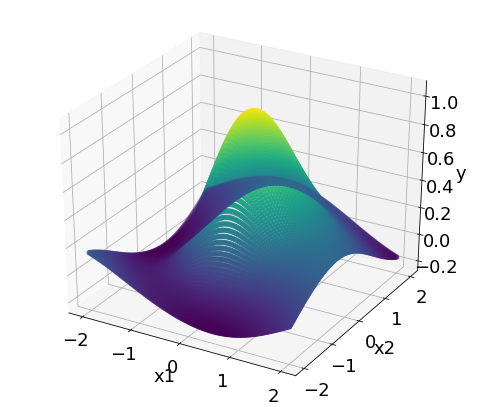

In [18]:
# define exploration space
N=100
x1 = np.linspace(-2, 2, N)
x2 = np.linspace(-2, 2, N)

# Make data set X (samples N^features , features=2) y (samples N^features)
X1,X2= np.meshgrid(x1,x2)
Z=func1(X1,X2) # Test function. this is replaced to a real test result.
X=np.concatenate([X1.reshape(-1)[:,None],X2.reshape(-1)[:,None]],axis=1)
y=Z.reshape(-1)

print('max of y : {0}'.format(max(y)))

# plot
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(X[:, 0], X[:, 1], y, c=y)
plt.tight_layout()
plt.show()

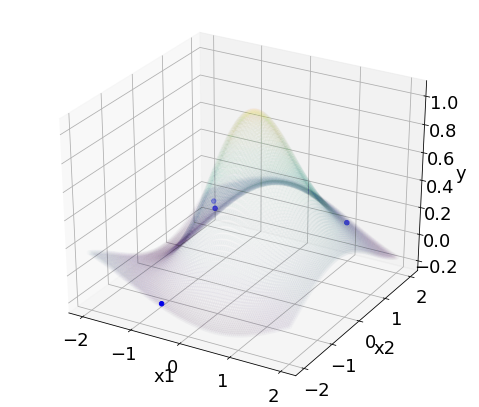

In [19]:
# initial x-y set which is already known by test
number_of_first_samples=4

bad_sample_number = np.where(y < 0.2)[0] # intentionaly choose not optimized data point for this test
bad_X = X[bad_sample_number, :]
bad_y = y[bad_sample_number]
np.random.seed(seed=1)
first_sample_numbers = np.random.randint(0, len(bad_y), number_of_first_samples)
X_train = bad_X[first_sample_numbers, :]
y_train = bad_y[first_sample_numbers]
X = np.delete(X, bad_sample_number[first_sample_numbers], 0)
y = np.delete(y, bad_sample_number[first_sample_numbers])

# plot
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(X[:, 0], X[:, 1], y, c=y,alpha=0.01)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='blue')

plt.tight_layout()
plt.show()

In [32]:
# initialize optimizer
bo=BayesianOptimizer(X_train,y_train,X,maximize=True,acquisition_function_flag=2)


X_original=np.concatenate([X1.reshape(-1)[:,None],X2.reshape(-1)[:,None]],axis=1)


for i in range(10):
  # fit and suggest next point
  selected_candidate_number, selected_X_candidate, cumulative_varianc=bo.fit_and_calc_next_candidate()
  inverse_estimated_y,inverse_estimated_y_std=(bo.predict(X_original))
  inverse_estimated_y=inverse_estimated_y.reshape(N,N)
  inverse_estimated_y_std=inverse_estimated_y_std.reshape(N,N)

  current_max_y=bo.get_current_optimized_value()

    
  # plot current status
  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)
  ax.scatter(X[:, 0], X[:, 1], y, c='lightsalmon',alpha=0.4)
  ax.plot_surface(X1,X2,inverse_estimated_y,alpha=0.2,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y+inverse_estimated_y_std,alpha=0.1,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y-inverse_estimated_y_std,alpha=0.1,color='cornflowerblue') 
  ax.scatter(bo.X_train[:, 0], bo.X_train[:, 1], bo.y_train, c='b',alpha=1)
  ax.scatter(bo.X_train[-1, 0], bo.X_train[-1, 1], bo.y_train[-1], c='r',alpha=1)
  ax.text(-1, -2, 0, 'current optimized y: {}'.format(np.round(current_max_y,2)), color='gray')
  plt.show()
  
  # calc next point
  next_y=func1(selected_X_candidate[0],selected_X_candidate[1])
  bo.update(selected_candidate_number,next_y)


Output hidden; open in https://colab.research.google.com to view.

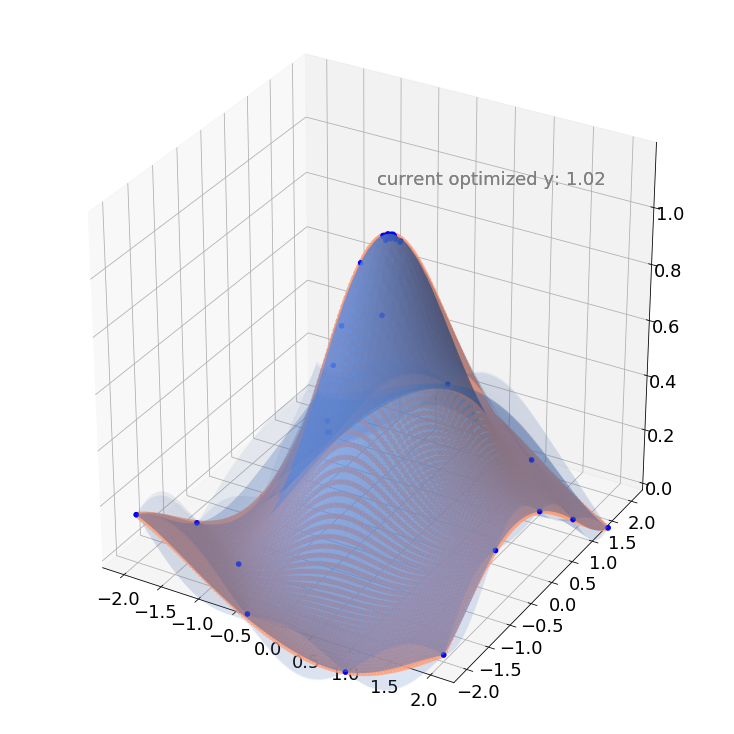

In [34]:



bo=BayesianOptimizer(X_train,y_train,X,maximize=True,acquisition_function_flag=2)

tot_frame=30
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ims=[]
def update_anim(i):
 
  # delete current plot
  if i != 0:
      plt.cla()                     

  #print(i)
      
  # fit and suggest next point
  selected_candidate_number, selected_X_candidate, cumulative_varianc=bo.fit_and_calc_next_candidate()
  inverse_estimated_y,inverse_estimated_y_std=(bo.predict(X_original))
  inverse_estimated_y=inverse_estimated_y.reshape(N,N)
  inverse_estimated_y_std=inverse_estimated_y_std.reshape(N,N)

  current_max_y=bo.get_current_optimized_value()

    
  # plot current status
  ax.scatter(X[:, 0], X[:, 1], y, c='lightsalmon',alpha=0.4)
  ax.plot_surface(X1,X2,inverse_estimated_y,alpha=0.3,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y+inverse_estimated_y_std,alpha=0.1,color='cornflowerblue') 
  ax.plot_surface(X1,X2,inverse_estimated_y-inverse_estimated_y_std,alpha=0.1,color='cornflowerblue') 
  ax.scatter(bo.X_train[:-1, 0], bo.X_train[:-1, 1], bo.y_train[:-1], c='b',alpha=1)
  ax.scatter(bo.X_train[-1, 0], bo.X_train[-1, 1], bo.y_train[-1], c='r',alpha=1)
  ax.text(0, 0, 1.2, 'current optimized y: {}'.format(np.round(current_max_y,2)), color='gray')
  ax.set_zlim(0,1.2)


  # calc next point
  next_y=func1(selected_X_candidate[0],selected_X_candidate[1])
  bo.update(selected_candidate_number,next_y)


anim = FuncAnimation(fig, update_anim,frames=tot_frame, interval=400)
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
#plt.rcParams['animation.ffmpeg_path'] = '/content/drive/My Drive/ColabSandbox/data/ffmpeg' # For google colab
HTML(anim.to_html5_video())